# `HFSAnomalyModel` Tutorial

Trey V. Wenger (c) August 2024

`HFSAnomalyModel` is like `HFSModel`, but allows for non-LTE variations in hyperfine component optical depths, often called "hyperfine anomalies." This notebook demonstrates this model and is otherwise nearly identical to the `HFSModel` notebook.

In [7]:
# General imports
import os
import pickle
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("pymc version:", pm.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import bayes_cn_hfs
print("bayes_cn_hfs version:", bayes_cn_hfs.__version__)

from bayes_cn_hfs import HFSModel

# Notebook configuration
pd.options.display.max_rows = None
    
# random state
rng = np.random.RandomState(seed=1234)

pymc version: 5.16.2
bayes_spec version: 1.6.0+0.gafc48ae.dirty
bayes_cn_hfs version: 0+untagged.1.g7eec682.dirty


## `get_molecule_data`

In [8]:
from bayes_cn_hfs import get_molecule_data
import astropy.constants as c

mol_data_12CN = get_molecule_data(
    "CN, v = 0, 1", # molecule name in JPLSpec
    vibrational_state = 0, # vibrational state number
    rot_state_lower = 0, # lower rotational state
)

# get molecular mass
mass_12CN = (12*c.m_p + 14*c.m_p).to('g').value

We identify those transitions which may be anomalous by flagging them in the `mol_data` dictionary. Here we mark the two satellite transitions at 113.499 GHz (F=1/2-1/2) and 113.508 GHz (F=3/2-3/2) as potentially anomalous.

In [9]:
mol_data_12CN['anomalous'] = [freq in [113499.643, 113508.934] for freq in mol_data_12CN['freq']]

In [10]:
print(mol_data_12CN)

{'freq': array([113123.3687, 113144.19  , 113170.535 , 113191.325 , 113488.142 ,
       113490.985 , 113499.643 , 113508.934 , 113520.4215]), 'Aul': array([1.26969616e-06, 1.03939111e-05, 5.07869910e-06, 6.59525390e-06,
       6.64784064e-06, 1.17706070e-05, 1.04919208e-05, 5.12459350e-06,
       1.28243028e-06]), 'degu': array([2, 2, 4, 4, 4, 6, 2, 4, 2]), 'Eu': array([7.49702428e-16, 7.49701340e-16, 7.50014955e-16, 7.50013660e-16,
       7.52119441e-16, 7.51999228e-16, 7.52195648e-16, 7.52118159e-16,
       7.52194276e-16]), 'relative_int': array([0.01204699, 0.09860036, 0.09633376, 0.1250773 , 0.12574146,
       0.33394774, 0.09921527, 0.09691221, 0.01212491]), 'log10_Q_terms': array([0.40307694, 0.97433601]), 'anomalous': [False, False, False, False, False, False, True, True, False]}


## Simulating Data

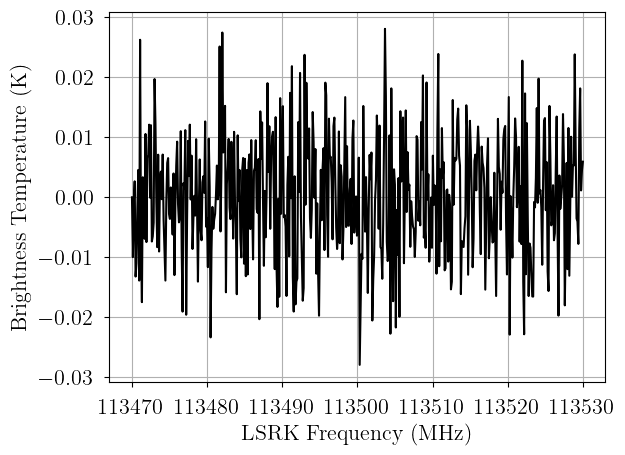

In [11]:
from bayes_spec import SpecData

# spectral axis definition
freq_axis = np.linspace(113470.0, 113530.0, 500) # MHz

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
noise = 0.01 # K

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
brightness_data = noise * np.random.randn(len(freq_axis)) # K

# HFSModel only expects a single observation named "observation"
observation = SpecData(
    freq_axis,
    brightness_data,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel="Brightness Temperature (K)",
)
dummy_data = {"observation": observation}

# Plot the dummy data
plt.plot(dummy_data["observation"].spectral, dummy_data["observation"].brightness, 'k-')
plt.xlabel(dummy_data["observation"].xlabel)
_ = plt.ylabel(dummy_data["observation"].ylabel)

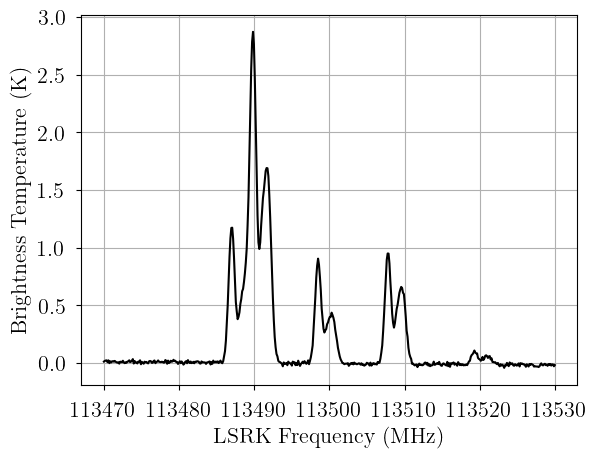

In [6]:
from bayes_cn_hfs import HFSAnomalyModel

# Initialize and define the model
n_clouds = 3
baseline_degree = 2
model = HFSAnomalyModel(
    dummy_data,
    mol_data=mol_data_12CN,
    mass=mass_12CN,
    bg_temp = 2.7, # assumed background temperature (K)
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N = [14.0, 0.2], # mean and width of log10(N_u) prior (cm-2)
    prior_log10_temp = [1.0, 0.1], # mean and width of log10(T) prior (K)
    prior_nonthermal_fwhm = 1.0, # width of nonthermal FWHM prior (km/s)
    prior_velocity = [0.0, 5.0], # mean and width of velocity prior (km/s)
    prior_rms = 0.1, # width of spectral rms prior (K)
    prior_hyperfine_anomaly = 0.05, # width of the hyperfine anomaly prior
)
model.add_likelihood()

hyperfine_anomaly = np.ones((len(mol_data_12CN['freq']), n_clouds))
for i, freq in enumerate(mol_data_12CN['freq']):
    if freq == 113499.643:
        hyperfine_anomaly[i] = np.array([0.75, 0.85, 0.95])
    if freq == 113508.934:
        hyperfine_anomaly[i] = np.array([1.25, 1.15, 1.05])

sim_brightness = model.model.observation.eval({
    "log10_N": [14.0, 13.5, 14.2],
    "log10_temp": [1.0, 1.2, 1.1],
    "nonthermal_fwhm": [3.0, 2.0, 2.5],
    "velocity": [-2.0, 0.0, 3.0],
    "rms_observation": noise,
    "hyperfine_anomaly": hyperfine_anomaly,
    "baseline_observation_norm": [-0.5, -3.0, 2.0], # normalized baseline coefficients
})

# Plot the simulated data
plt.plot(dummy_data["observation"].spectral, sim_brightness, 'k-')
plt.xlabel(dummy_data["observation"].xlabel)
_ = plt.ylabel(dummy_data["observation"].ylabel)

In [12]:
# Now we pack the simulated spectrum into a new SpecData instance
observation = SpecData(
    freq_axis,
    sim_brightness,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel="Brightness Temperature (K)",
)
data = {"observation": observation}

## Model Definition

In [13]:
# Initialize and define the model
model = HFSAnomalyModel(
    data,
    mol_data=mol_data_12CN,
    mass=mass_12CN,
    bg_temp = 2.7, # assumed background temperature (K)
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N = [14.0, 0.2], # mean and width of log10(N_u) prior (cm-2)
    prior_log10_temp = [1.0, 0.1], # mean and width of log10(T) prior (K)
    prior_nonthermal_fwhm = 1.0, # width of nonthermal FWHM prior (km/s)
    prior_velocity = [0.0, 5.0], # mean and width of velocity prior (km/s)
    prior_rms = 0.1, # width of spectral rms prior (K)
    prior_baseline_coeffs = [1.0, 1.0, 1.0], # width of normalized polynomial baseline coeffs
    prior_hyperfine_anomaly = 0.05, # width of the hyperfine anomaly prior
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

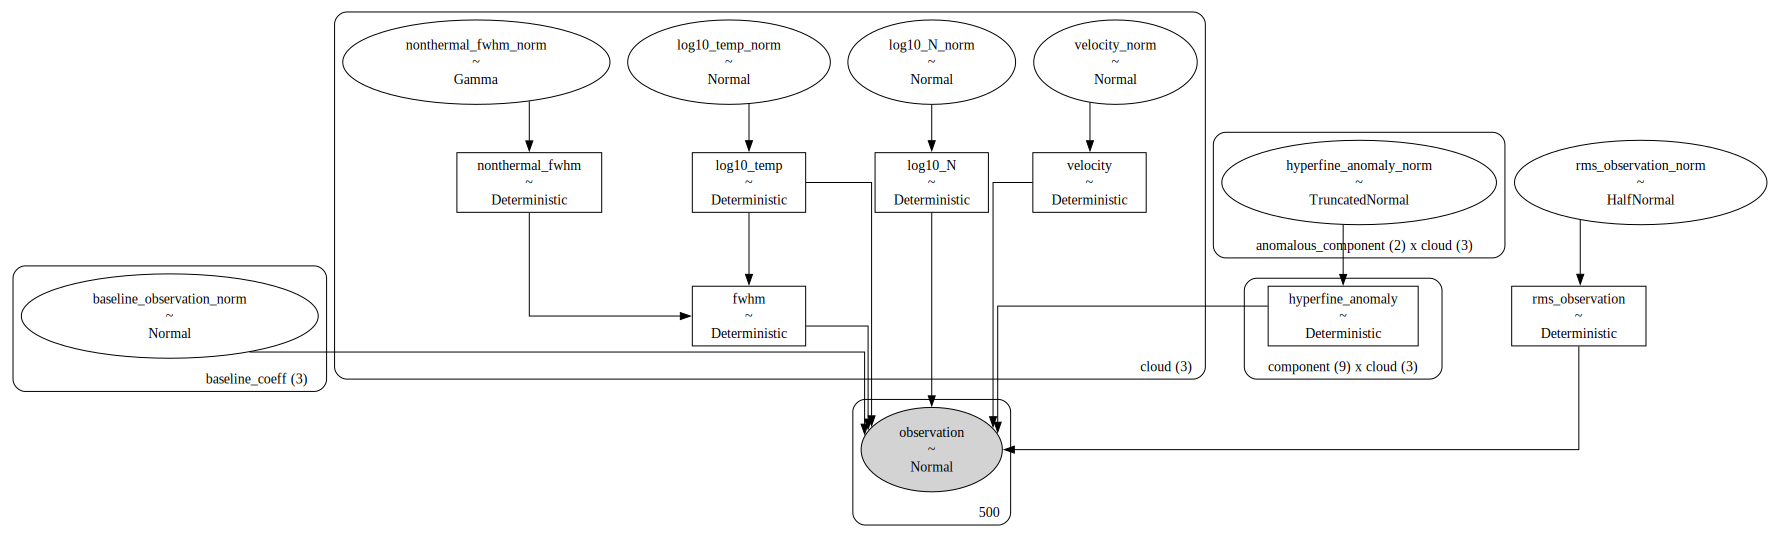

In [14]:
# Plot model graph
model.graph().render('hfs_anomaly_model', format='png')
model.graph()

In [15]:
# model string representation
print(model.model.str_repr())

baseline_observation_norm ~ Normal(0, <constant>)
             log10_N_norm ~ Normal(0, 1)
          log10_temp_norm ~ Normal(0, 1)
     nonthermal_fwhm_norm ~ Gamma(2, f())
            velocity_norm ~ Normal(0, 1)
     rms_observation_norm ~ HalfNormal(0, 1)
   hyperfine_anomaly_norm ~ TruncatedNormal(0, 1, -20, inf)
                  log10_N ~ Deterministic(f(log10_N_norm))
               log10_temp ~ Deterministic(f(log10_temp_norm))
          nonthermal_fwhm ~ Deterministic(f(nonthermal_fwhm_norm))
                 velocity ~ Deterministic(f(velocity_norm))
                     fwhm ~ Deterministic(f(nonthermal_fwhm_norm, log10_temp_norm))
          rms_observation ~ Deterministic(f(rms_observation_norm))
        hyperfine_anomaly ~ Deterministic(f(hyperfine_anomaly_norm))
              observation ~ Normal(f(baseline_observation_norm, log10_temp_norm, log10_N_norm, hyperfine_anomaly_norm, nonthermal_fwhm_norm, velocity_norm), rms_observation)


Sampling: [baseline_observation_norm, hyperfine_anomaly_norm, log10_N_norm, log10_temp_norm, nonthermal_fwhm_norm, observation, rms_observation_norm, velocity_norm]


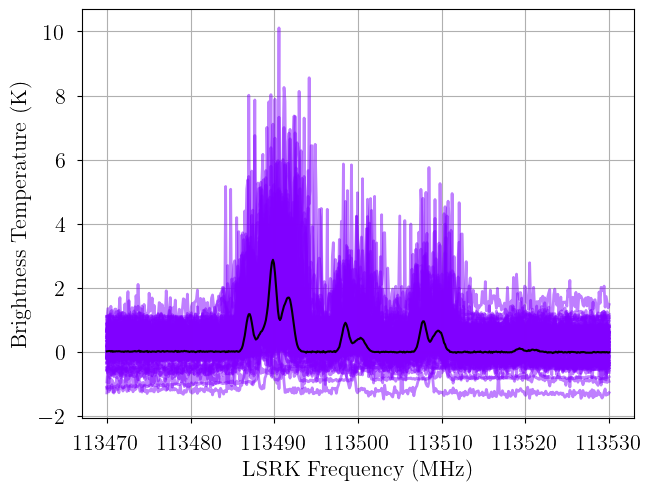

In [17]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

## Variational Inference

In [18]:
start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.1, # VI absolute convergence threshold
    learning_rate = 1e-2, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 4600
Interrupted at 4,599 [4%]: Average Loss = 169.89


Runtime: 0.50 minutes


In [20]:
pm.summary(model.trace.posterior)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
baseline_observation_norm[0],-0.437,0.002,-0.441,-0.433,0.000,0.000,1030.0,965.0,NaN
baseline_observation_norm[1],-0.071,0.006,-0.081,-0.059,0.000,0.000,751.0,941.0,NaN
baseline_observation_norm[2],0.118,0.038,0.045,0.188,0.001,0.001,1060.0,982.0,NaN
fwhm[0],3.157,0.016,3.129,3.186,0.000,0.000,1082.0,1071.0,NaN
fwhm[1],5.193,0.042,5.116,5.275,0.001,0.001,1050.0,1025.0,NaN
fwhm[2],2.305,0.008,2.290,2.320,0.000,0.000,858.0,944.0,NaN
"hyperfine_anomaly[113123.3687, 0]",1.000,0.000,1.000,1.000,0.000,0.000,1000.0,1000.0,NaN
"hyperfine_anomaly[113123.3687, 1]",1.000,0.000,1.000,1.000,0.000,0.000,1000.0,1000.0,NaN
"hyperfine_anomaly[113123.3687, 2]",1.000,0.000,1.000,1.000,0.000,0.000,1000.0,1000.0,NaN
"hyperfine_anomaly[113144.19, 0]",1.000,0.000,1.000,1.000,0.000,0.000,1000.0,1000.0,NaN


Sampling: [observation]


Output()

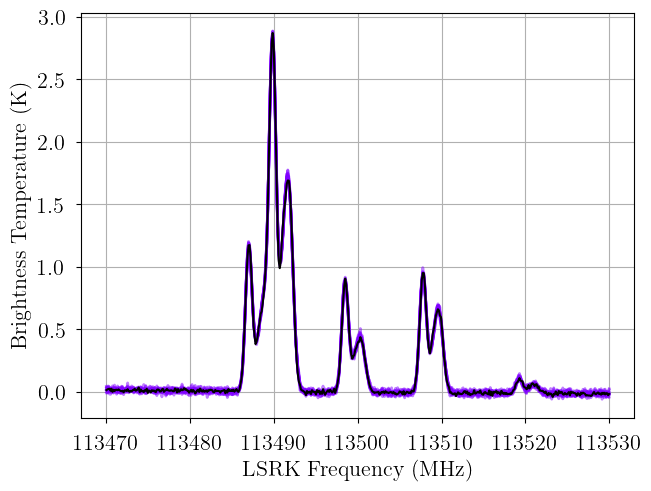

In [21]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

## Posterior Sampling: MCMC

In [23]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 4, # number of independent chains
    cores = 4, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.1, "learning_rate": 1e-2}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.8}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 4600
Interrupted at 4,599 [4%]: Average Loss = 169.89
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_observation_norm, log10_N_norm, log10_temp_norm, nonthermal_fwhm_norm, velocity_norm, rms_observation_norm, hyperfine_anomaly_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 351 seconds.


There were 2 divergences in converged chains.
Runtime: 6.68 minutes


In [24]:
model.solve(p_threshold=0.9)

GMM converged to unique solution


In [26]:
print("solutions:", model.solutions)
display(az.summary(model.trace["solution_0"]))
# this also works: az.summary(model.trace.solution_0)

solutions: [0]


/home/twenger/miniconda3/envs/bayes_spec-dev/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/twenger/miniconda3/envs/bayes_spec-dev/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
baseline_observation_norm[0],-0.434,0.002,-0.438,-0.431,0.000,0.000,3271.0,3112.0,1.0
baseline_observation_norm[1],-0.072,0.003,-0.078,-0.065,0.000,0.000,7145.0,3023.0,1.0
baseline_observation_norm[2],0.057,0.033,-0.001,0.125,0.001,0.000,3258.0,3239.0,1.0
fwhm[0],3.018,0.034,2.956,3.082,0.001,0.001,1242.0,1652.0,1.0
fwhm[1],1.987,0.056,1.888,2.098,0.002,0.001,1290.0,1825.0,1.0
fwhm[2],2.497,0.008,2.483,2.512,0.000,0.000,2543.0,2948.0,1.0
"hyperfine_anomaly[113123.3687, 0]",1.000,0.000,1.000,1.000,0.000,0.000,4000.0,4000.0,NaN
"hyperfine_anomaly[113123.3687, 1]",1.000,0.000,1.000,1.000,0.000,0.000,4000.0,4000.0,NaN
"hyperfine_anomaly[113123.3687, 2]",1.000,0.000,1.000,1.000,0.000,0.000,4000.0,4000.0,NaN
"hyperfine_anomaly[113144.19, 0]",1.000,0.000,1.000,1.000,0.000,0.000,4000.0,4000.0,NaN


Sampling: [observation]


Output()

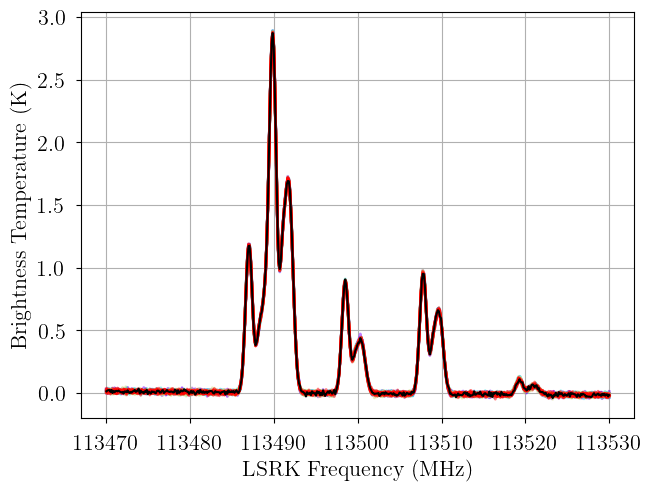

In [27]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

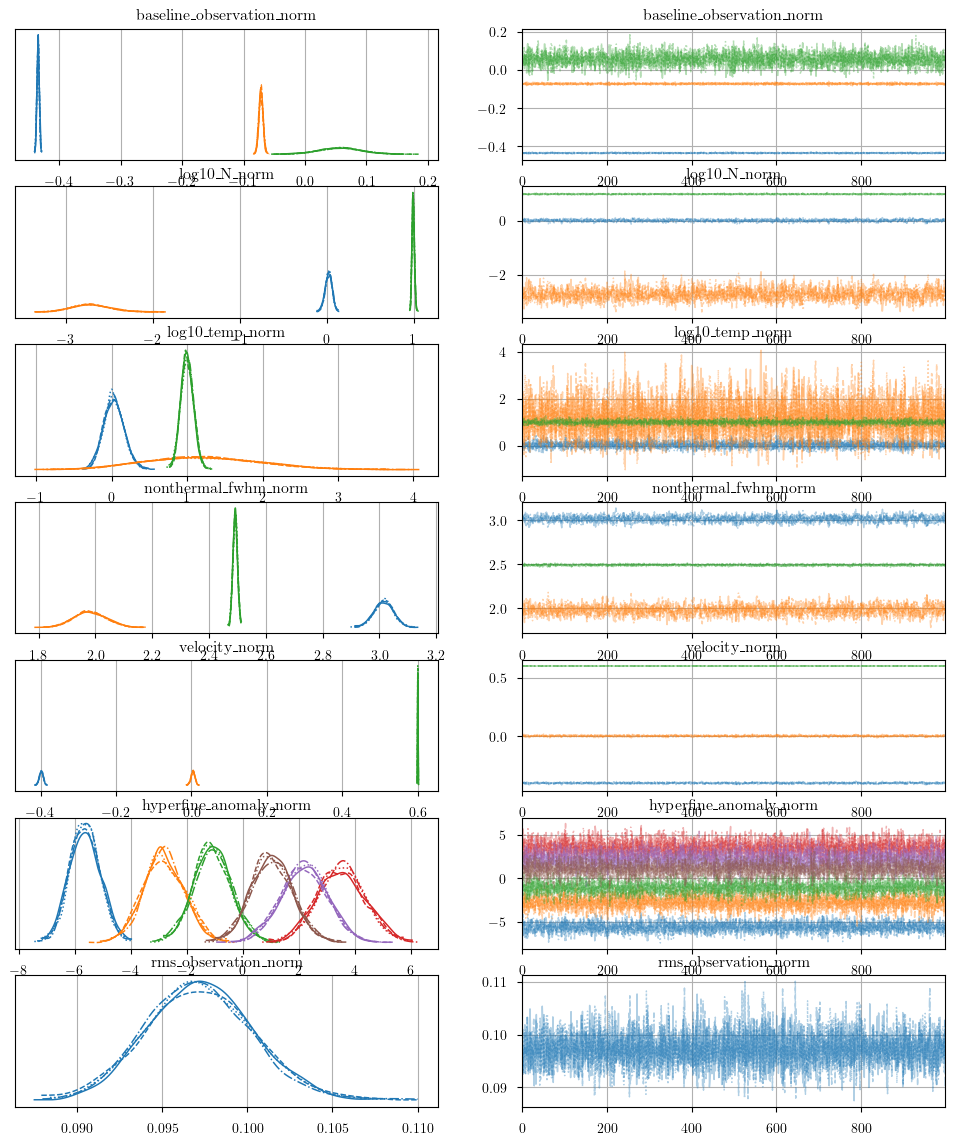

In [28]:
from bayes_spec.plots import plot_traces

_ = plot_traces(model.trace.solution_0, model.baseline_freeRVs + model.cloud_freeRVs + model.hyper_freeRVs)

array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='log10_temp_norm'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='nonthermal_fwhm_norm'>, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='velocity_norm'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='hyperfine_anomaly_norm\n113499.643'>, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='log10_N_norm', ylabel='hyperfine_anomaly_norm\n113508.934'>,
        <Axes: xlabel='log10_temp_norm'>,
        <Axes: xlabel='nonthermal_fwhm_norm'>,
        <Axes: xlabel='velocity_norm'>,
        <Axes: xlabel='hyperfine_anomaly_norm\n113499.643'>,
        <Axes: xlabel='hyperfine_anomaly_norm\n113508.934'>]],
      dtype=object)

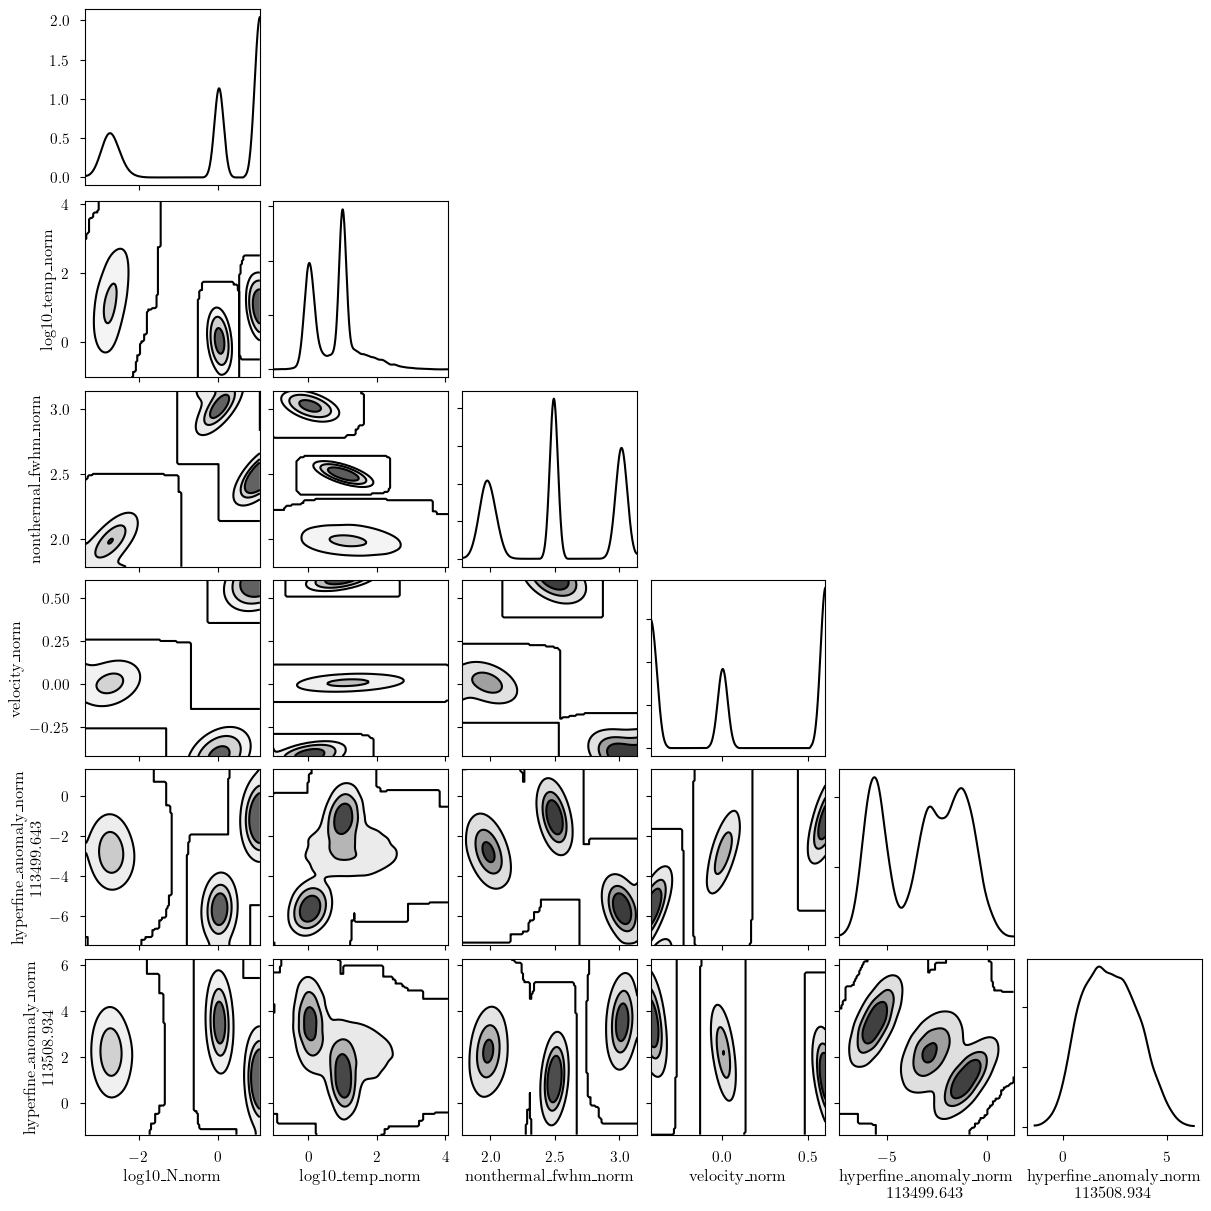

In [29]:
from bayes_spec.plots import plot_pair

plot_pair(
    model.trace.solution_0, # samples
    model.cloud_freeRVs, # var_names to plot
    labeller=model.labeller, # label manager
)

array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='log$_{10}$ $T$ (K)'>, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='$\\Delta V_{\\rm nt}$ (km s$^{-1}$)'>, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='$v_{\\rm LSR}$ (km s$^{-1}$)'>, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='log$_{10}$ $N$ (cm$^{-2}$)', ylabel='$\\Delta V$ (km s$^{-1}$)'>,
        <Axes: xlabel='log$_{10}$ $T$ (K)'>,
        <Axes: xlabel='$\\Delta V_{\\rm nt}$ (km s$^{-1}$)'>,
        <Axes: xlabel='$v_{\\rm LSR}$ (km s$^{-1}$)'>,
        <Axes: xlabel='$\\Delta V$ (km s$^{-1}$)'>]], dtype=object)

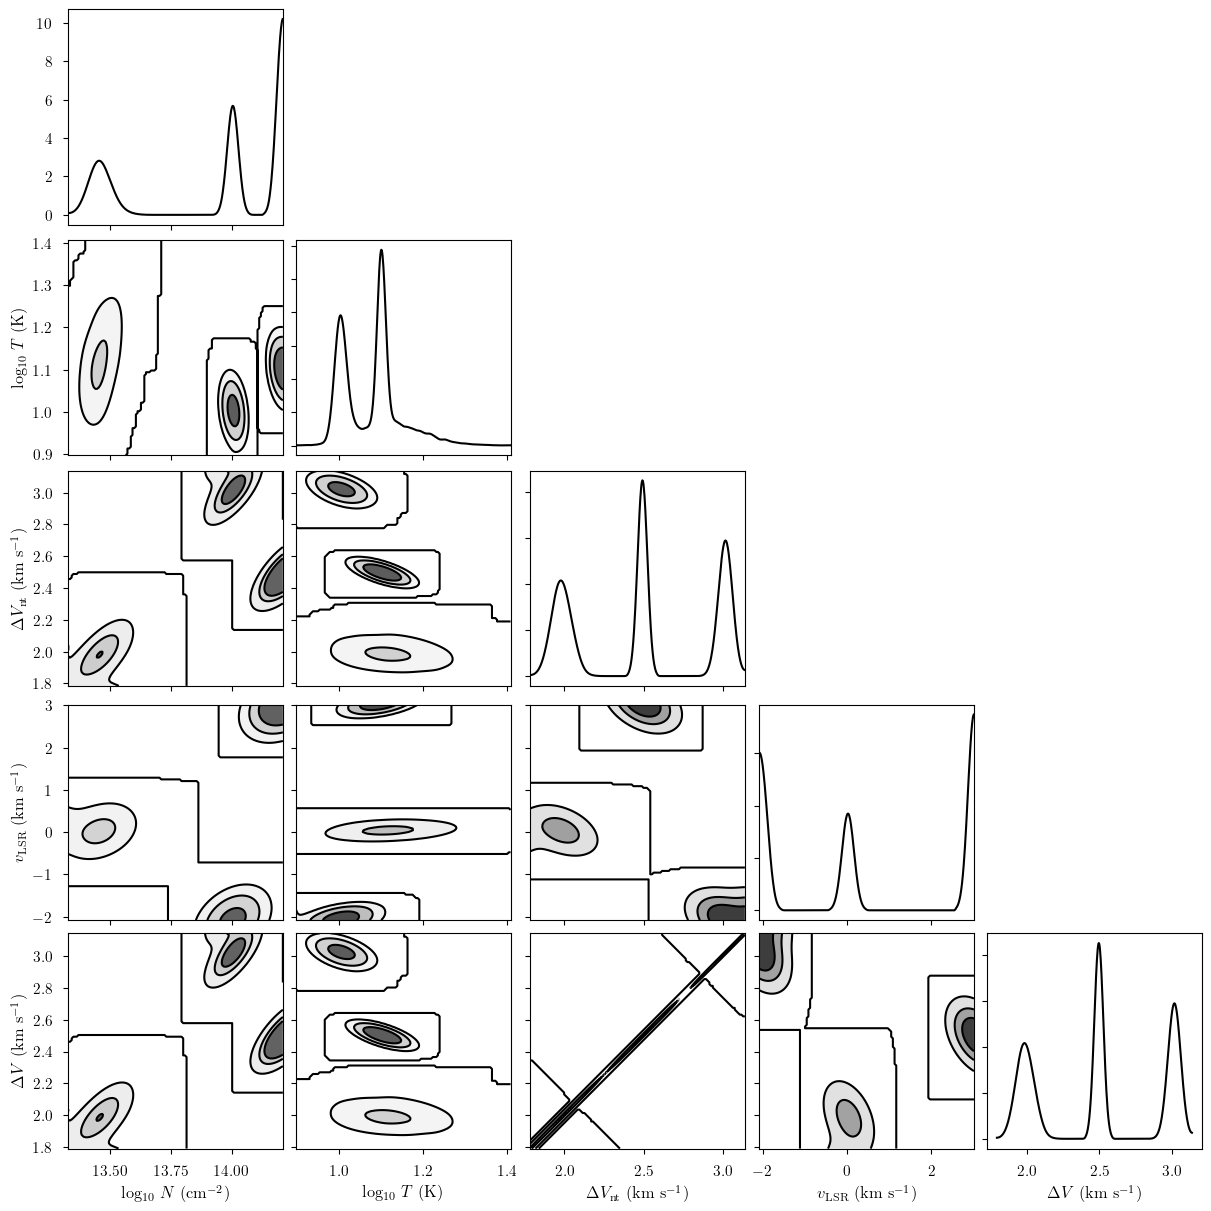

In [33]:
var_names = [param for param in model.cloud_deterministics if param not in ["hyperfine_anomaly"]]
plot_pair(
    model.trace.solution_0, # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
)

In [36]:
point_stats = az.summary(model.trace.solution_0, model.cloud_deterministics, kind='stats', hdi_prob=0.68)
print("BIC:", model.bic())
display(point_stats)

BIC: -3016.993626488857


,mean,sd,hdi_16%,hdi_84%
log10_N[0],14.004,0.008,13.997,14.012
log10_N[1],13.458,0.043,13.410,13.493
log10_N[2],14.199,0.003,14.196,14.201
log10_temp[0],1.003,0.013,0.990,1.016
log10_temp[1],1.123,0.076,1.039,1.192
log10_temp[2],1.100,0.008,1.091,1.107
nonthermal_fwhm[0],3.015,0.034,2.986,3.051
nonthermal_fwhm[1],1.981,0.056,1.921,2.033
nonthermal_fwhm[2],2.492,0.008,2.485,2.500
velocity[0],-1.991,0.025,-2.015,-1.965


In [37]:
az.summary(model.trace.solution_0, var_names=["hyperfine_anomaly"])

/home/twenger/miniconda3/envs/bayes_spec-dev/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/twenger/miniconda3/envs/bayes_spec-dev/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"hyperfine_anomaly[113123.3687, 0]",1.000,0.000,1.000,1.000,0.0,0.0,4000.0,4000.0,NaN
"hyperfine_anomaly[113123.3687, 1]",1.000,0.000,1.000,1.000,0.0,0.0,4000.0,4000.0,NaN
"hyperfine_anomaly[113123.3687, 2]",1.000,0.000,1.000,1.000,0.0,0.0,4000.0,4000.0,NaN
"hyperfine_anomaly[113144.19, 0]",1.000,0.000,1.000,1.000,0.0,0.0,4000.0,4000.0,NaN
"hyperfine_anomaly[113144.19, 1]",1.000,0.000,1.000,1.000,0.0,0.0,4000.0,4000.0,NaN
"hyperfine_anomaly[113144.19, 2]",1.000,0.000,1.000,1.000,0.0,0.0,4000.0,4000.0,NaN
"hyperfine_anomaly[113170.535, 0]",1.000,0.000,1.000,1.000,0.0,0.0,4000.0,4000.0,NaN
"hyperfine_anomaly[113170.535, 1]",1.000,0.000,1.000,1.000,0.0,0.0,4000.0,4000.0,NaN
"hyperfine_anomaly[113170.535, 2]",1.000,0.000,1.000,1.000,0.0,0.0,4000.0,4000.0,NaN
"hyperfine_anomaly[113191.325, 0]",1.000,0.000,1.000,1.000,0.0,0.0,4000.0,4000.0,NaN
